<a href="https://colab.research.google.com/github/MinGyeongdo/MultiLabel-foodimg-classification/blob/main/model_create.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
import random
from random import randrange
import cv2
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Model, load_model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Activation, Flatten, Dropout, BatchNormalization
import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input


In [26]:
base_path = '/content/drive/MyDrive/food_classification/'
train_path = base_path + 'train'
val_path = base_path +'valid'

labels = pd.read_csv(base_path + 'food_label_ver2.csv')

In [27]:
labels

,id,foods,is_low_kcal,nutrients
0,1,hamburger,0,"fats, protein"
1,2,hamburger,0,"fats, protein"
2,3,sweetpotato,1,"carbohydrate,fiber"
3,4,sweetpotato,1,"carbohydrate,fiber"
4,5,sweetpotato,1,"carbohydrate,fiber"
...,...,...,...,...
973,974,hamburger,0,"fats, protein,carbohydrate"
974,975,hamburger,0,"fats, protein,carbohydrate"
975,976,hamburger,0,"fats, protein,carbohydrate"
976,977,hamburger,0,"fats, protein,carbohydrate"


In [28]:
"""
파일명 변경시도..
학습시 파일명에 괄호같은 특수문자가 들어간다면, 이미지제너레이터 사용이 안되어서
코랩에서 os 라이브러리가 잘 사용이 안되는지 모르겠지만 디렉토리를 못찾는다.
결국 batch namer라는 프로그램이용해서 변경하였다.

"""
# test_id_list = [i for i in range(1,979)]
# print(test_id_list)
# start_num = [3,52,78,113,148,171,207,248,295,323,365,403,436,464,500,534,589,612,645,695,738,764,792,836,946]

# val_id_list = []
# for num in start_num:
#   atom = [i for i in range(num, num+4)]
#   val_id_list.extend(atom)

# train_id_list = [ x for x in test_id_list if x not in val_id_list]
# print(train_id_list)
# import os
# for id in train_id_list:
#   os.path.rename(train_path+ f'/food({id}).jpg', train_path + f'/{id}.jpg')
# for id in val_id_list:
#   os.path.rename(val_path+ f'/food({id}).jpg', val_path + f'/{id}.jpg')

'\n파일명 변경시도..\n학습시 파일명에 괄호같은 특수문자가 들어간다면, 이미지제너레이터 사용이 안되어서\n코랩에서 os 라이브러리가 잘 사용이 안되는지 모르겠지만 디렉토리를 못찾는다.\n결국 batch namer라는 프로그램이용해서 변경하였다.\n\n'

In [29]:
def EDA(df):
  """
  학습을 위한 데이터셋으로 전처리
  1. path : 이미지의 경로를 포함
  2. foods : 깨진 문자 치환 caf?_beverage -> cafe_beverage
  < labels columns >
  3. 음식 카테고리와, 영양 카테고리로 나눠져 있는 컬럼을 합쳐줌
  4. 쉼표를 제거 해주고, 공백2개를 1개로 치환
  5. 카테고리가 담긴 리스트로 해당열을 채워줌
  6. 라벨링 해준다.

  """
  df['foods'] = df['foods'].apply(lambda x : x.replace('?','e')) # 2
  df['labels'] = df['foods'] +',' + df['nutrients'] # 3 
  df['labels'] = df['labels'].apply(lambda x: x.replace(',', ' ')) # 4
  df['labels'] = df['labels'].apply(lambda x: x.replace('  ', ' ')) # 4
  df['labels'] = [x.split(' ') for x in df['labels']] #5
  
  print("--------------------------------------------- EDA processing complete ---------------------------------------------")
  display(df)
  print('\n')
  df = Multilabeling(df) # 6
  # fig, ax = plt.subplots(figsize=(20, 6))
  # df.iloc[:, 1:].sum().plot.bar(title='Target Class Distribution');
  return df


In [30]:
def Multilabeling(df):
  """
  리스트내에 문자열과 쉼표로 이루어진 카테고리를 분류화하여 자동으로 라벨링해주는 함수
  sklearn의 MultiLabelBinarizer 활용 -> 원핫인코딩
  """
  from sklearn.preprocessing import MultiLabelBinarizer
  
  mlb = MultiLabelBinarizer()
  label = mlb.fit_transform(df['labels'].values)
  print('Labels:', mlb.classes_)
  new_df = pd.DataFrame(columns=mlb.classes_, data=label)
  new_df['path'] = df['id'].apply(lambda x: base_path + 'images/'+ str(x) + '.jpg')
  new_df.insert(0, 'is_low_kcal', labels['is_low_kcal'])
  
  
  print("--------------------------------------------- Multi labeling complete ---------------------------------------------")
  display(new_df)
  

  
  return new_df


[sklearn MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html)

In [31]:
data = EDA(labels)

--------------------------------------------- EDA processing complete ---------------------------------------------


,id,foods,is_low_kcal,nutrients,labels
0,1,hamburger,0,"fats, protein","[hamburger, fats, protein]"
1,2,hamburger,0,"fats, protein","[hamburger, fats, protein]"
2,3,sweetpotato,1,"carbohydrate,fiber","[sweetpotato, carbohydrate, fiber]"
3,4,sweetpotato,1,"carbohydrate,fiber","[sweetpotato, carbohydrate, fiber]"
4,5,sweetpotato,1,"carbohydrate,fiber","[sweetpotato, carbohydrate, fiber]"
...,...,...,...,...,...
973,974,hamburger,0,"fats, protein,carbohydrate","[hamburger, fats, protein, carbohydrate]"
974,975,hamburger,0,"fats, protein,carbohydrate","[hamburger, fats, protein, carbohydrate]"
975,976,hamburger,0,"fats, protein,carbohydrate","[hamburger, fats, protein, carbohydrate]"
976,977,hamburger,0,"fats, protein,carbohydrate","[hamburger, fats, protein, carbohydrate]"




Labels: ['bowl_of_rice' 'cafe_beverage' 'cake' 'carbohydrate' 'chicken_chest'
 'cold_noodle' 'cookie' 'cutlet' 'fats' 'fiber' 'french_fries'
 'fried_chicken' 'fried_rice' 'hamburger' 'icecream' 'jjajang' 'jjampon'
 'korean_noodle' "korean_table_d'hote" 'oatmeal' 'omelet_rice' 'pasta'
 'pizza' 'protein' 'ramen' 'salad' 'salmon' 'shave_ice'
 'stir_fried_ricecake' 'sugars' 'sweetpotato' 'waffle']
--------------------------------------------- Multi labeling complete ---------------------------------------------


,is_low_kcal,bowl_of_rice,cafe_beverage,cake,carbohydrate,chicken_chest,cold_noodle,cookie,cutlet,fats,...,protein,ramen,salad,salmon,shave_ice,stir_fried_ricecake,sugars,sweetpotato,waffle,path
0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...
1,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,/content/drive/MyDrive/food_classification/ima...
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,/content/drive/MyDrive/food_classification/ima...
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,/content/drive/MyDrive/food_classification/ima...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...
974,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...
975,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...
976,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...


(600, 340, 4)


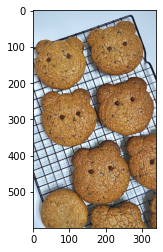

In [32]:
from PIL import Image

img = np.array(Image.open(data.path[362]))
print(img.shape)
plt.imshow(np.array(img))

In [33]:
def train_test_splits(df):
  """
  test data의 선정은 음식카테고리당 4개씩 임의로선정하여 id를 통해 나눠주었음

  """
  start_num = [3,52,78,113,148,171,207,248,295,323,365,403,436,464,500,534,589,612,645,695,738,764,792,836,946]

  val_id_list = []
  for num in start_num:
    atom = [i for i in range(num, num+4)]
    val_id_list.extend(atom)
  print("Validation_id List :", val_id_list)

  train = df.drop(index=val_id_list, axis='indexes')
  val = df.loc[val_id_list,:]
  
  print("Tran set : ")
  display(train)
  print("Val set : ")
  display(val)

  print(f'Train : {train.shape}, Val : {val.shape}')
  return train, val

  


In [34]:
train, test = train_test_splits(data)

Validation_id List : [3, 4, 5, 6, 52, 53, 54, 55, 78, 79, 80, 81, 113, 114, 115, 116, 148, 149, 150, 151, 171, 172, 173, 174, 207, 208, 209, 210, 248, 249, 250, 251, 295, 296, 297, 298, 323, 324, 325, 326, 365, 366, 367, 368, 403, 404, 405, 406, 436, 437, 438, 439, 464, 465, 466, 467, 500, 501, 502, 503, 534, 535, 536, 537, 589, 590, 591, 592, 612, 613, 614, 615, 645, 646, 647, 648, 695, 696, 697, 698, 738, 739, 740, 741, 764, 765, 766, 767, 792, 793, 794, 795, 836, 837, 838, 839, 946, 947, 948, 949]
Tran set : 


,is_low_kcal,bowl_of_rice,cafe_beverage,cake,carbohydrate,chicken_chest,cold_noodle,cookie,cutlet,fats,...,protein,ramen,salad,salmon,shave_ice,stir_fried_ricecake,sugars,sweetpotato,waffle,path
0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...
1,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,/content/drive/MyDrive/food_classification/ima...
7,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,/content/drive/MyDrive/food_classification/ima...
8,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,/content/drive/MyDrive/food_classification/ima...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...
974,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...
975,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...
976,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...


Val set : 


,is_low_kcal,bowl_of_rice,cafe_beverage,cake,carbohydrate,chicken_chest,cold_noodle,cookie,cutlet,fats,...,protein,ramen,salad,salmon,shave_ice,stir_fried_ricecake,sugars,sweetpotato,waffle,path
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,/content/drive/MyDrive/food_classification/ima...
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,/content/drive/MyDrive/food_classification/ima...
5,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,/content/drive/MyDrive/food_classification/ima...
6,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,/content/drive/MyDrive/food_classification/ima...
52,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,/content/drive/MyDrive/food_classification/ima...
946,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...
947,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...
948,0,0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/food_classification/ima...


Train : (878, 34), Val : (100, 34)


[케라스 ImageDataGenerator](https://keras.io/ja/preprocessing/image/)

In [35]:
from keras.preprocessing.image import ImageDataGenerator as IDG

Gen = IDG(rescale=1./255, validation_split=0.1)
                

trainSet = Gen.flow_from_dataframe(
    dataframe=data,
    x_col='path',
    y_col = data.columns.tolist()[:-1],
    batch_size=128,
    seed=42,
    shuffle=True,
    target_size=(224,224),
    class_mode='raw',
    color_mode='rgb',
    subset='training'
    )

valSet = Gen.flow_from_dataframe(
    dataframe=data,
    x_col='path',
    y_col = data.columns.tolist()[:-1],
    batch_size=128,
    seed=42,
    shuffle=False,
    target_size=(224,224),
    class_mode='raw',
    color_mode='rgb',
    subset='validation'
    )


Found 881 validated image filenames.
Found 97 validated image filenames.


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 33)                42273     
                                                                 
Total params: 2,300,257
Trainable params: 2,266,145
Non-trainable params: 34,112
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


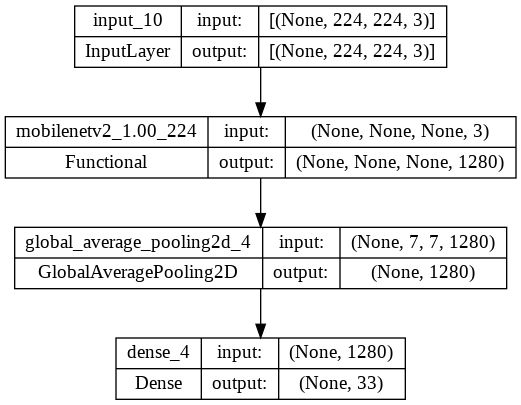

In [36]:
import tensorflow as tf

inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.MobileNetV2(include_top=False)(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(33, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs, outputs)
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-4))

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [37]:
rlp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.01)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model.fit(trainSet, validation_data=valSet, epochs=10, callbacks=[rlp, es])


Epoch 1/10
7/7 [==============================] - 18s 2s/step - loss: 0.7753 - val_loss: 0.9665 - lr: 1.0000e-04
Epoch 2/10
7/7 [==============================] - ETA: 0s - loss: 0.4929
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
7/7 [==============================] - 6s 842ms/step - loss: 0.4929 - val_loss: 1.2808 - lr: 1.0000e-04
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 0.3869
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-09.
7/7 [==============================] - 6s 852ms/step - loss: 0.3869 - val_loss: 1.2629 - lr: 1.0000e-06
Epoch 4/10
7/7 [==============================] - ETA: 0s - loss: 0.3855
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999939225291e-11.
Restoring model weights from the end of the best epoch: 1.
7/7 [==============================] - 7s 874ms/step - loss: 0.3855 - val_loss: 1.2423 - lr: 1.0000e-08
Epoch 4: early stopping


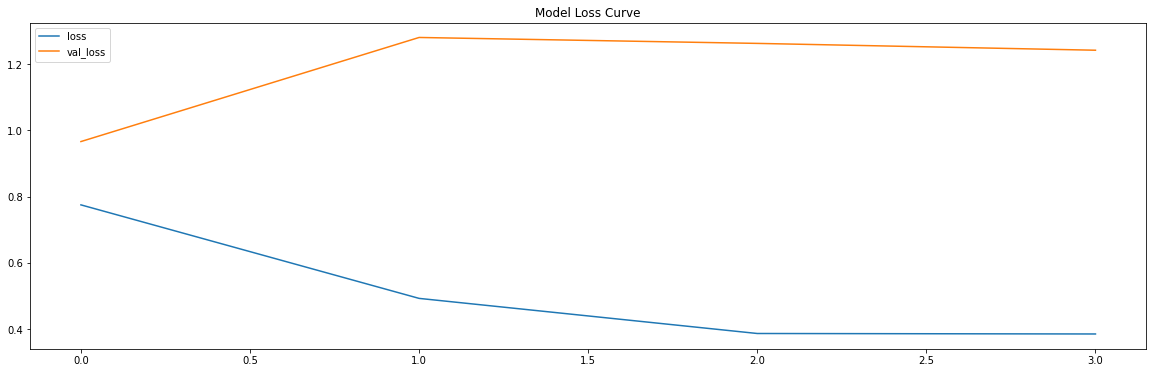

In [38]:
fix, ax = plt.subplots(figsize=(20, 6))
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(ax=ax, title='Model Loss Curve')

In [39]:
model.save('mobilenetv2.h5')

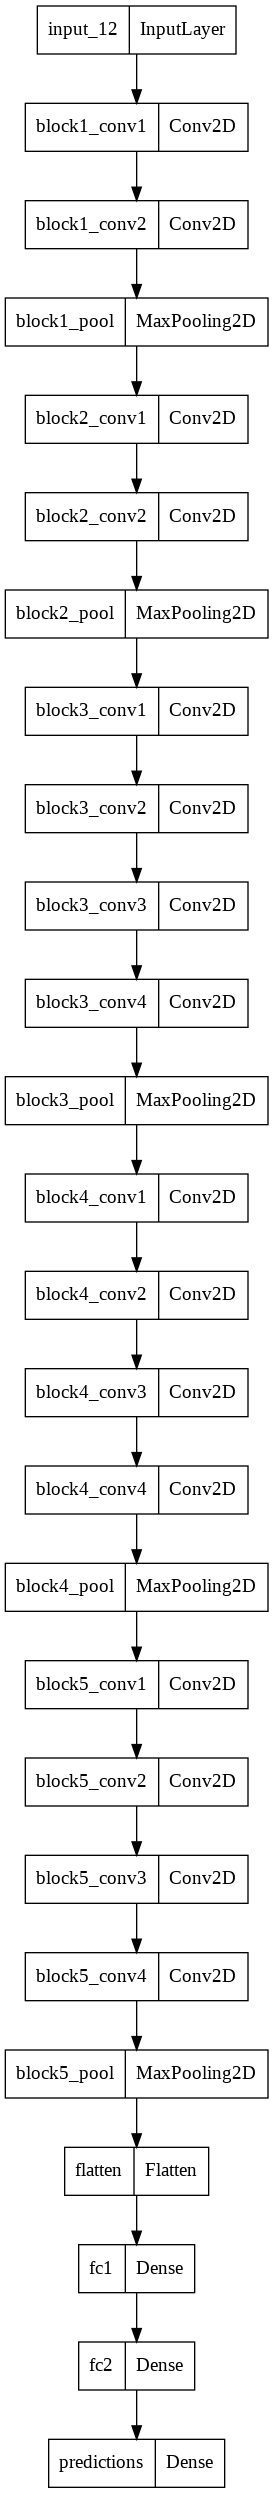

In [40]:
from keras.utils.vis_utils import plot_model

# 모델
model = VGG19()
plot_model(model, to_file='vgg.png')

In [41]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     